In [1]:
import sys
sys.path.append('..')

# OS and system
import os
import gc
import argparse
from argparse import Namespace
import pickle

# utils
from functools import partial
from copy import deepcopy
from tqdm import tqdm
import time

# mathematics
import matplotlib.pyplot as plt
import numpy as np
import random
from sklearn.metrics import r2_score

# data handling
import pandas as pd

# Torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

# Torchvision
import torchvision

# logging
# import wandb

# my_lib
from model.net import *
from model.train import train, test
from misc.utils import save_checkpoint, load_transform, load_dataset


In [57]:
args = Namespace()

args.seed = 1
args.batch_size = 10
args.epochs = 10000
args.lr = 1e-3

args.n_dim = 100         # Size of the matrix (n x n)
args.rank = 5           # Rank of X*
args.m_samples = 5 * args.n_dim * args.rank   # Number of samples
args.m_train = args.n_dim * args.rank

args.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Reproducibility
torch.manual_seed(args.seed)
np.random.seed(args.seed)
random.seed(args.seed)


In [58]:
# Generate low-rank matrix X_star = U U^T
U_true = torch.randn(args.n_dim, args.rank, device=args.device)
X_star = U_true @ U_true.T  # [n, n]
X_star /= torch.norm(X_star, p='fro')  # Normalize to unit Frobenius norm

# Generate random sensing matrices A_i and labels y_i = Tr(A_i^T X_star)
A = torch.randn(args.m_samples, args.n_dim, args.n_dim, device=args.device)   # [m, n, n]
y = torch.einsum('mij,ij->m', A, X_star)  # [m]


# Split into train/test
A_train, y_train = A[:args.m_train], y[:args.m_train]
A_test, y_test = A[args.m_train:], y[args.m_train:]

print(y_train.mean(), y_train.std())
# y_train += torch.randn_like(y_train) * 0.2  # Add noise to training labels


tensor(-0.0437, device='cuda:0') tensor(1.0312, device='cuda:0')


In [59]:
from pyhessian import hessian

class MatrixSensingModel(nn.Module):
    def __init__(self, args):
        super().__init__()
        U_init = torch.eye(args.n_dim, args.n_dim, device=args.device)
        U_init /= torch.norm(U_init, p='fro')  # Normalize to unit Frobenius norm
        self.U = nn.Parameter(U_init)  # Initialize U as a learnable parameter

    def forward(self, A):
        X = self.U @ self.U.T
        return torch.einsum('mij,ij->m', A, X)


def update_label_noise(label_noise, args):
    return args.rho * label_noise + torch.randn_like(label_noise) * args.sigma_rho


def train(model, optimizer, criterion, A_train, y_train, A_test, y_test, args):
    """Train the model with noisy labels and compute Hessian eigenvalues and trace."""
    train_loss, test_loss, top_eigvals, trace_hessian = validate(model, criterion, A_train, y_train, A_test, y_test)
    model.train()
    print(f"Initial Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Top 5 Eigenvalues: {top_eigvals[0]}, Trace: {trace_hessian}")

    train_losses, test_losses = [train_loss], [test_loss]
    top_eigvals_res, trace_hessian_res = [top_eigvals], [trace_hessian]

    label_noise = torch.randn(args.m_train, device=args.device) * args.sigma_rho  # Initial label noise
    for t in range(1, args.tot_iter + 1):
        # Update label noise
        label_noise = update_label_noise(label_noise, args)
        y_train_noisy = y_train + label_noise

        # Sample a batch of data
        batch_idx = torch.randint(0, args.m_train, (args.batch_size,), device=args.device)

        A_batch = A_train[batch_idx]
        y_batch = y_train_noisy[batch_idx]

        optimizer.zero_grad()
        loss = criterion(model(A_batch), y_batch)
        loss.backward()
        optimizer.step()

        # Logging
        if t % args.log_iter == 0:  # Optional: log less frequently
            train_loss, test_loss, top_eigvals, trace_hessian = validate(model, criterion, A_train, y_train, A_test, y_test)
            model.train()

            train_losses.append(train_loss)
            test_losses.append(test_loss)
            top_eigvals_res.append(top_eigvals)
            trace_hessian_res.append(trace_hessian)
            print(f"Iter {t}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Top 5 Eigenvalues: {top_eigvals[0]}, Trace: {trace_hessian}")
            
            # Optional: update the log_iter dynamically
            # if tot_t > 0 and tot_t % (args.log_iter * 10) == 0:
            #     args.log_iter *= 10  # Increase log_iter to log less frequently

    return {'train_loss': train_losses, 'test_loss': test_losses, 'top_eigvals': top_eigvals_res, 'trace_hessian': trace_hessian_res}


def validate(model, criterion, A_train, y_train, A_test=None, y_test=None):
    """Validate the model and compute Hessian eigenvalues and trace."""
    if A_test is not None and y_test is not None:
        assert A_test.shape[0] == y_test.shape[0], "Test data and labels must have the same number of samples."

    model.eval()
    with torch.no_grad():
        train_loss = criterion(model(A_train), y_train).item()

    # Compute Hessian eigenvalues and trace
    hessian_comp = hessian(model, criterion, data=(A_train, y_train), cuda=True)
    top_eigvals, _ = hessian_comp.eigenvalues(top_n=5)
    trace_hessian = np.mean(hessian_comp.trace())

    if A_test is not None and y_test is not None:
        with torch.no_grad():
            test_loss = criterion(model(A_test), y_test).item()
        return train_loss, test_loss, np.array(top_eigvals), trace_hessian
    else:
        return train_loss, None, np.array(top_eigvals), trace_hessian


In [60]:
args.log_iter = 1000  # Logging interval
args.tot_iter = 5 * args.log_iter * 10**2  # Number of epochs

args.lr = 5e-2
args.batch_size = args.m_train // 10  # Batch size for training

args.sigma = 0.0 # Standard deviation of noise
args.rho = 0.0
args.sigma_rho = args.sigma * np.sqrt(1 - (args.rho ** 2))  # Adjusted noise standard deviation

criterion = nn.MSELoss()

# Model and optimizer
model_clean = MatrixSensingModel(args).to(args.device)
optim_clean = optim.SGD(model_clean.parameters(), lr=args.lr)

res_clean = train(model_clean, optim_clean, criterion, A_train, y_train, A_test, y_test, args)


args.sigma = 0.05 # Standard deviation of noise
args.rho = 0.0
args.sigma_rho = args.sigma * np.sqrt(1 - (args.rho ** 2))  # Adjusted noise standard deviation

model_noisy = MatrixSensingModel(args).to(args.device)
optim_noisy = optim.SGD(model_noisy.parameters(), lr=args.lr)

res_noisy = train(model_noisy, optim_noisy, criterion, A_train, y_train, A_test, y_test, args)



Initial Train Loss: 1.0418, Test Loss: 0.9631, Top 5 Eigenvalues: -3.185274124145508, Trace: 176.35879319997935
Iter 1000, Train Loss: 0.0000, Test Loss: 0.6110, Top 5 Eigenvalues: 5.579631805419922, Trace: 983.4648864746093
Iter 2000, Train Loss: 0.0000, Test Loss: 0.6110, Top 5 Eigenvalues: 5.583510398864746, Trace: 955.0396270751953
Iter 3000, Train Loss: 0.0000, Test Loss: 0.6110, Top 5 Eigenvalues: 5.584779739379883, Trace: 964.952811686198
Iter 4000, Train Loss: 0.0000, Test Loss: 0.6110, Top 5 Eigenvalues: 5.580502033233643, Trace: 966.522959391276
Iter 5000, Train Loss: 0.0000, Test Loss: 0.6110, Top 5 Eigenvalues: 5.5795698165893555, Trace: 977.0825576782227
Iter 6000, Train Loss: 0.0000, Test Loss: 0.6110, Top 5 Eigenvalues: 5.58115291595459, Trace: 1019.5157012939453
Iter 7000, Train Loss: 0.0000, Test Loss: 0.6110, Top 5 Eigenvalues: 5.582311630249023, Trace: 990.1959075927734
Iter 8000, Train Loss: 0.0000, Test Loss: 0.6110, Top 5 Eigenvalues: 5.583571910858154, Trace: 101

In [55]:
# args.rho = 0.99
# args.sigma = 0.05
# args.sigma_rho = args.sigma * np.sqrt(1 - (args.rho ** 2))  # Adjusted noise standard deviation


# model_noisy_tau = MatrixSensingModel(args).to(args.device)
# optim_noisy_tau = optim.SGD(model_noisy_tau.parameters(), lr=args.lr)

# res_noisy_tau = train(model_noisy_tau, optim_noisy_tau, criterion, A_train, y_train, A_test, y_test, args)
res_noisy_tau2 = train(model_noisy_tau, optim_noisy_tau, criterion, A_train, y_train, A_test, y_test, args)

Initial Train Loss: 0.0024, Test Loss: 0.2175, Top 5 Eigenvalues: 6.877119064331055, Trace: 317.79801712036135
Iter 1000, Train Loss: 0.0024, Test Loss: 0.2146, Top 5 Eigenvalues: 6.792388916015625, Trace: 321.4567047119141
Iter 2000, Train Loss: 0.0020, Test Loss: 0.2270, Top 5 Eigenvalues: 6.848474502563477, Trace: 320.90165032280817
Iter 3000, Train Loss: 0.0024, Test Loss: 0.2239, Top 5 Eigenvalues: 6.876315116882324, Trace: 311.60858154296875
Iter 4000, Train Loss: 0.0026, Test Loss: 0.2094, Top 5 Eigenvalues: 6.797639846801758, Trace: 340.32144927978516
Iter 5000, Train Loss: 0.0023, Test Loss: 0.2171, Top 5 Eigenvalues: 6.894134521484375, Trace: 326.19437408447266
Iter 6000, Train Loss: 0.0023, Test Loss: 0.2152, Top 5 Eigenvalues: 6.7823286056518555, Trace: 306.952138100901
Iter 7000, Train Loss: 0.0025, Test Loss: 0.2083, Top 5 Eigenvalues: 6.898412704467773, Trace: 334.18937530517576
Iter 8000, Train Loss: 0.0022, Test Loss: 0.2187, Top 5 Eigenvalues: 6.795870780944824, Trace

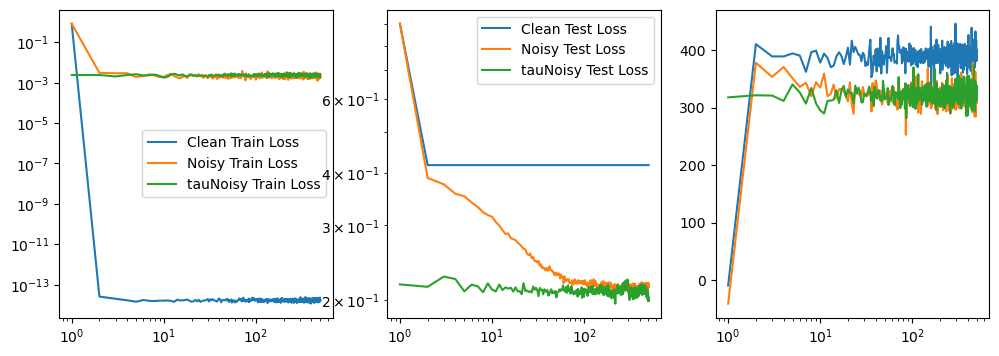

In [56]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

x_axis = np.arange(1, len(res_clean['train_loss']) + 1)

axs[0].plot(x_axis, res_clean['train_loss'], label='Clean Train Loss')
axs[0].plot(x_axis, res_noisy['train_loss'], label='Noisy Train Loss')
axs[0].plot(x_axis, res_noisy_tau2['train_loss'], label='tauNoisy Train Loss')


axs[1].plot(x_axis, res_clean['test_loss'], label='Clean Test Loss')
axs[1].plot(x_axis, res_noisy['test_loss'], label='Noisy Test Loss')
axs[1].plot(x_axis, res_noisy_tau2['test_loss'], label='tauNoisy Test Loss')

axs[2].plot(x_axis, res_clean['trace_hessian'], label='Clean Test Loss')
axs[2].plot(x_axis, res_noisy['trace_hessian'], label='Noisy Test Loss')
axs[2].plot(x_axis, res_noisy_tau2['trace_hessian'], label='tauNoisy Test Loss')


axs[0].legend()
axs[1].legend()

axs[0].set_xscale('log')
axs[0].set_yscale('log')

axs[1].set_xscale('log')
axs[1].set_yscale('log')

axs[2].set_xscale('log')
# axs[2].set_ylim(100, 300)

# print(len(losses_clean['train_loss']), len(losses_noisy['train_loss']))
# print(losses_clean['train_loss'][-1], losses_noisy['train_loss'][-1], losses_noisy_tau['train_loss'][-1])

In [ ]:
args.log_iter = 1000  # Logging interval
args.tot_iter = args.log_iter * 10**2  # Number of epochs

args.sigma = 0.1 # Standard deviation of noise
args.lr = 1e-2
args.batch_size = args.m_train // 10 
args.tau = 0

# Model and optimizer
model = MatrixSensingModel(args).to(args.device)
optimizer = optim.SGD(model.parameters(), lr=args.lr)

temp_res = train(model, optimizer, A_train, y_train, A_test, y_test, args, inject_noise=False)
temp_res = train(model, optimizer, A_train, y_train, A_test, y_test, args, inject_noise=False)

In [ ]:
args.log_iter = 1000  # Logging interval
args.tot_iter = args.log_iter * 10**2  # Number of epochs

args.sigma = 0.1 # Standard deviation of noise
args.lr = 1e-2
args.batch_size = args.m_train // 10 
args.tau = 0

# Initialize and run
U0 = torch.eye(args.n_dim, device=args.device)
losses_clean, U_clean = train_gd(U0, A_train, y_train, A_test, y_test, args, inject_noise=False)
losses_noisy, U_noisy = train_gd(U0, A_train, y_train, A_test, y_test, args, inject_noise=True)

args.tau = 5 * args.lr
losses_noisy_tau, U_noisy_tau = train_gd(U0, A_train, y_train, A_test, y_test, args, inject_noise=True)

In [ ]:
# args.epochs = 300000  # Number of epochs
# args.log_iter = 1000  # Logging interval
# args.sigma = 0.1
# args.lr = 1e-3
# args.batch_size = 100

# # Initialize and run
# model_clean = MatrixSensingModel(args).to(args.device)
# optim_clean = optim.SGD(model_clean.parameters(), lr=args.lr)

# model_noisy = MatrixSensingModel(args).to(args.device)
# optim_noisy = optim.SGD(model_noisy.parameters(), lr=args.lr)

# losses_clean = train(model_clean, optim_clean, A_train, y_train, A_test, y_test, args, inject_noise=False)
# losses_noisy = train(model_noisy, optim_noisy, A_train, y_train, A_test, y_test, args, inject_noise=True)

NameError: name 'MatrixSensingModel' is not defined

100 100
6.4423887231879196e-12 5.737694664276205e-05 0.0003634473541751504


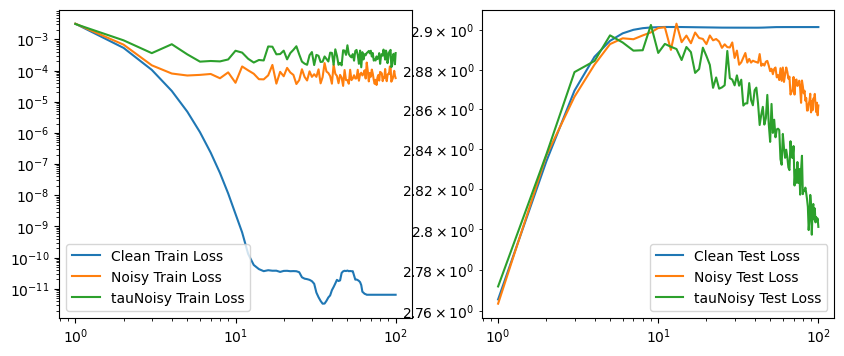

In [397]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

x_axis = np.arange(1, len(losses_clean['train_loss']) + 1)

axs[0].plot(x_axis, losses_clean['train_loss'], label='Clean Train Loss')
axs[0].plot(x_axis, losses_noisy['train_loss'], label='Noisy Train Loss')
axs[0].plot(x_axis, losses_noisy_tau['train_loss'], label='tauNoisy Train Loss')


axs[1].plot(x_axis, losses_clean['test_loss'], label='Clean Test Loss')
axs[1].plot(x_axis, losses_noisy['test_loss'], label='Noisy Test Loss')
axs[1].plot(x_axis, losses_noisy_tau['test_loss'], label='tauNoisy Test Loss')


axs[0].legend()
axs[1].legend()

axs[0].set_xscale('log')
axs[0].set_yscale('log')

axs[1].set_xscale('log')
axs[1].set_yscale('log')

print(len(losses_clean['train_loss']), len(losses_noisy['train_loss']))
print(losses_clean['train_loss'][-1], losses_noisy['train_loss'][-1], losses_noisy_tau['train_loss'][-1])

10000 10000


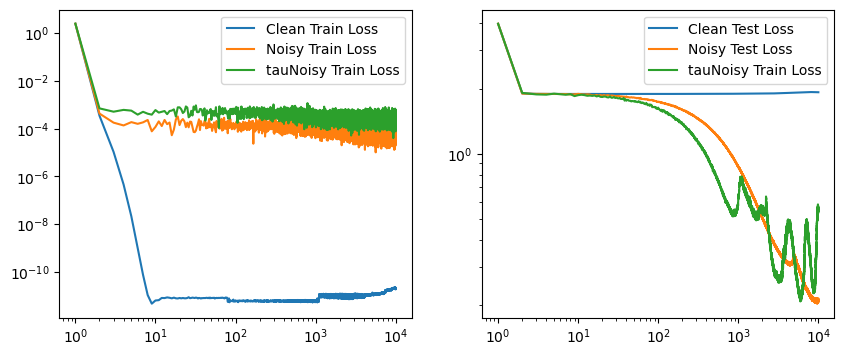

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

x_axis = np.arange(1, len(losses_clean['train_loss']) + 1)

axs[0].plot(x_axis, losses_clean['train_loss'], label='Clean Train Loss')
axs[0].plot(x_axis, losses_noisy['train_loss'], label='Noisy Train Loss')
axs[0].plot(x_axis, losses_noisy_tau['train_loss'], label='tauNoisy Train Loss')


axs[1].plot(x_axis, losses_clean['test_loss'], label='Clean Test Loss')
axs[1].plot(x_axis, losses_noisy['test_loss'], label='Noisy Test Loss')
axs[1].plot(x_axis, losses_noisy_tau['test_loss'], label='tauNoisy Test Loss')


axs[0].legend()
axs[1].legend()

axs[0].set_xscale('log')
axs[0].set_yscale('log')

axs[1].set_xscale('log')
axs[1].set_yscale('log')

print(len(losses_clean['train_loss']), len(losses_noisy['train_loss']))

In [171]:
def hessian_trace_rademacher(loss_fn, U_, A, y, num_samples=100, tol=1e-4):
    U = U_.clone().requires_grad_(True)  # Safe local copy

    trace_estimates = []
    trace = 0.

    for _ in range(num_samples):
        # Rademacher vector
        v = torch.randint_like(U, low=0, high=2, dtype=torch.float32)
        v = 2.0 * v - 1.0  # in {-1, +1}
        v_flat = v.view(-1)

        # Compute gradient
        loss = loss_fn(U, A, y)
        grad = torch.autograd.grad(loss, U, create_graph=True)[0]
        grad_flat = grad.view(-1)

        Hv = torch.autograd.grad(
            grad_flat, U,
            grad_outputs=v_flat,
            retain_graph=True,
            allow_unused=True
        )[0]

        if Hv is None:
            continue

        trace_estimates.append(torch.sum(v * Hv).cpu().item())
        if abs(np.mean(trace_estimates) - trace)/(abs(trace) + 1e-6) < tol:
            return trace_estimates
        else:
            trace = np.mean(trace_estimates)

    return trace_estimates

In [228]:
temp_hess = hessian_trace_rademacher(loss, U_noisy, A_train, y_train)

np.mean(temp_hess), np.std(temp_hess), len(temp_hess)

(50.073320369720456, 19.23609470405483, 100)

In [133]:
from torch.autograd.functional import hessian

u_flat = U_noisy_tau.view(-1).detach().clone().requires_grad_(True)

def flat_loss(u_flattened, loss_fn, U, A, y):
    U_ = u_flattened.view_as(U)
    return loss_fn(U_, A, y)

# Compute full Hessian (VERY expensive if n*r is large)
H = torch.autograd.functional.hessian(
    lambda u: flat_loss(u, loss, U_noisy, A_train, y_train),
    u_flat
)
# Compute trace directly
trace_direct = torch.trace(H).item()

In [134]:
trace_direct

61.1923942565918

300 300


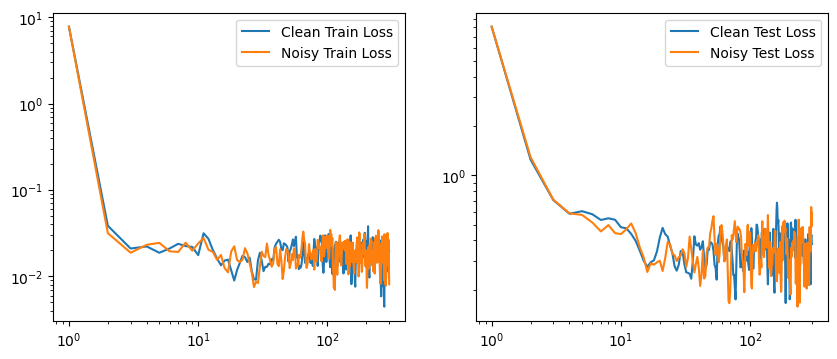

In [62]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

x_axis = np.arange(1, len(losses_clean['train_loss']) + 1)

axs[0].plot(x_axis, losses_clean['train_loss'], label='Clean Train Loss')
axs[0].plot(x_axis, losses_noisy['train_loss'], label='Noisy Train Loss')

axs[1].plot(x_axis, losses_clean['test_loss'], label='Clean Test Loss')
axs[1].plot(x_axis, losses_noisy['test_loss'], label='Noisy Test Loss')

axs[0].legend()
axs[1].legend()

axs[0].set_xscale('log')
axs[0].set_yscale('log')

axs[1].set_xscale('log')
axs[1].set_yscale('log')

print(len(losses_clean['train_loss']), len(losses_noisy['train_loss']))

100 100


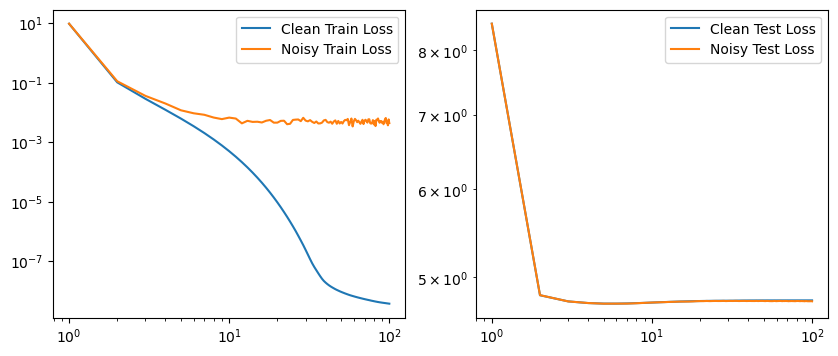

In [39]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

x_axis = np.arange(1, len(losses_clean['train_loss']) + 1)

axs[0].plot(x_axis, losses_clean['train_loss'], label='Clean Train Loss')
axs[0].plot(x_axis, losses_noisy['train_loss'], label='Noisy Train Loss')

axs[1].plot(x_axis, losses_clean['test_loss'], label='Clean Test Loss')
axs[1].plot(x_axis, losses_noisy['test_loss'], label='Noisy Test Loss')

axs[0].legend()
axs[1].legend()

axs[0].set_xscale('log')
axs[0].set_yscale('log')

axs[1].set_xscale('log')
axs[1].set_yscale('log')

print(len(losses_clean['train_loss']), len(losses_noisy['train_loss']))

In [160]:
cov = trajs.var(axis=0).mean(axis=0)

(H0[np.diag_indices_from(H0)] @ cov) * H0[np.diag_indices_from(H0)]

# (torch.trace(H0 @ cov) * H0)[np.diag_indices_from(H0)]

tensor([0.1205, 0.1177, 0.1149, 0.1122, 0.1094, 0.1066, 0.1038, 0.1010, 0.0983,
        0.0955, 0.0927, 0.0899, 0.0871, 0.0844, 0.0816, 0.0788, 0.0760, 0.0732,
        0.0704, 0.0677, 0.0649, 0.0621, 0.0593, 0.0565, 0.0538, 0.0510, 0.0482,
        0.0454, 0.0426, 0.0399, 0.0371, 0.0343, 0.0315, 0.0287, 0.0260, 0.0232,
        0.0204, 0.0176, 0.0148, 0.0121])

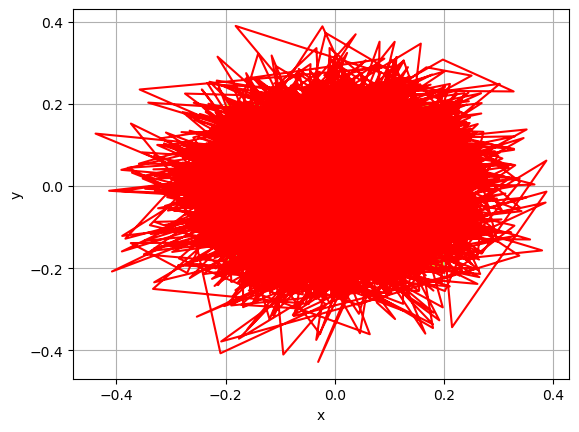

In [101]:
# Plotting the trajectory over contours
# x_vals = np.linspace(-0.2, 0.2, 100)
# y_vals = np.linspace(-0.2, 0.2, 100)
# X, Y = np.meshgrid(x_vals, y_vals)
# Z = 0.5 * X**2 + Y**2

plt.contour(X, Y, Z, levels=30, cmap="viridis")
# plt.plot(trajectory[:, 0], trajectory[:, 1], color='red', marker='o', markersize=2, linewidth=1)
# plt.title("SGD Dynamics Near a Local Minimum")
idx = 15
plt.plot(trajs[idx, :, 0].flatten(), trajs[idx, :, 2].flatten(), c='red', alpha=1)
# plt.plot(trajs[:, :, 0].flatten(), trajs[:, :, 1].flatten(), c='red', alpha=1)

plt.xlabel("x")
plt.ylabel("y")
# plt.axis('equal')
plt.grid(True)
# plt.show()

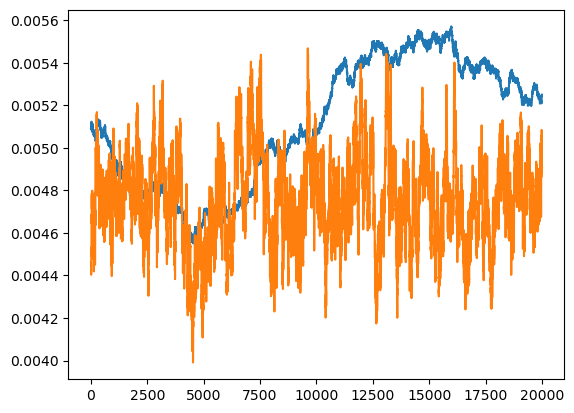

In [141]:
trajs_1 = (trajs[:, :, 0] < 0.1) * (trajs[:, :, 0] > -0.1)

vars = trajs**2

plt.plot(vars.mean(axis=0)[:, 0])
plt.plot(vars.mean(axis=0)[:, 1])

(array([3.13744278e-04, 1.42836211e-03, 3.14569921e-03, 3.38513563e-03,
        7.62068338e-03, 4.16123989e-03, 1.02627405e-02, 2.23336387e-02,
        2.07318916e-02, 2.63710322e-02, 4.98853402e-02, 6.72238397e-02,
        9.37187183e-02, 9.46682076e-02, 1.03040226e-01, 1.24184939e-01,
        1.47657965e-01, 2.08136303e-01, 2.66938585e-01, 3.08831703e-01,
        3.68905476e-01, 4.24925342e-01, 5.29781982e-01, 6.05452148e-01,
        7.17202906e-01, 8.16907535e-01, 9.95692235e-01, 1.18631665e+00,
        1.39233931e+00, 1.60442218e+00, 1.93116208e+00, 2.18221530e+00,
        2.47185906e+00, 2.75313906e+00, 2.97437832e+00, 3.18216785e+00,
        3.50206317e+00, 3.84354904e+00, 3.99164460e+00, 4.29522521e+00,
        4.56348483e+00, 4.67986744e+00, 4.94527859e+00, 5.27031766e+00,
        5.46516937e+00, 5.48180607e+00, 5.26708114e+00, 5.25597624e+00,
        5.28602139e+00, 5.37459635e+00, 5.29557407e+00, 5.10606427e+00,
        4.97951800e+00, 4.89985172e+00, 4.69817194e+00, 4.513434

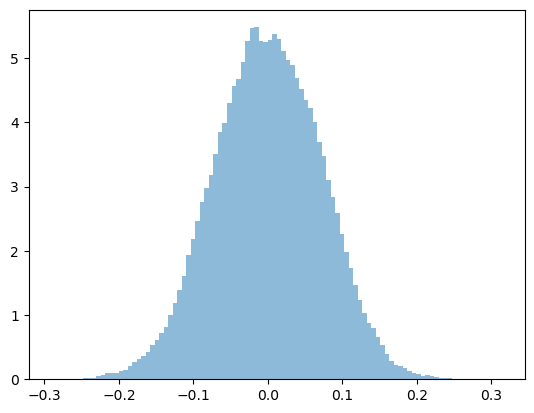

In [ ]:
plt.hist(trajs[:, :, 0].flatten(), bins=100, density=True, alpha=0.5, label='x')
plt.plot()

In [226]:
trjs = np.zeros((2000, 5000))

eps_t = np.random.randn(5000)/2

temp_lr = 1e-2
temp_tau = 1e-1
temp_sigma = 1

for i in range(2000):
    eps_t = (1 - temp_lr/temp_tau) * eps_t + temp_sigma * np.sqrt(temp_lr/temp_tau) * np.random.randn(5000)

    trjs[i, :] = eps_t

0.7184953414996846


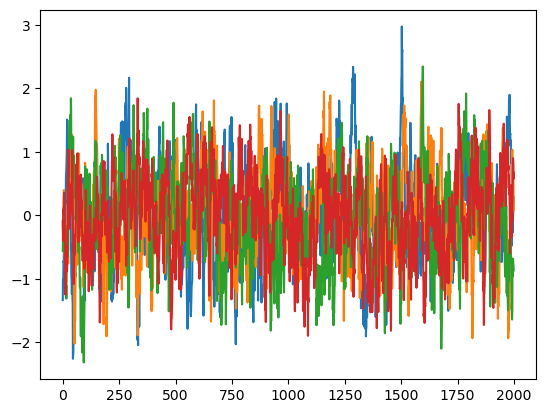

In [227]:
print(eps_t.std())

plt.plot(trjs[:, 0], label='eps_t')
plt.plot(trjs[:, 1], label='eps_t')
plt.plot(trjs[:, 2], label='eps_t')
plt.plot(trjs[:, 3], label='eps_t')

In [235]:
temp_log_iter = 1

for i in range(0, 301):
    if i % temp_log_iter == 0:
        print(i)

    if i > 0 and i % (temp_log_iter * 10) == 0:
        temp_log_iter *= 10
        print('log_iter is changed', temp_log_iter)

0
1
2
3
4
5
6
7
8
9
10
log_iter is changed 10
20
30
40
50
60
70
80
90
100
log_iter is changed 100
200
300
